In [1]:
from shapely.geometry import Polygon, Point
import itertools
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
import numpy as np
import shapely.wkt as wkt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from tqdm import tqdm
from skimage.measure import label, regionprops
import os
import dask
import time
import gc
import re
from rioxarray.exceptions import NoDataInBounds
from rioxarray.merge import merge_arrays
from scipy.interpolate import NearestNDInterpolator

In [2]:
import distributed
dask.config.set({"distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_": 0})
dask.config.set(scheduler='processes')

In [3]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))

print(os.environ["MALLOC_TRIM_THRESHOLD_"])

#os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

0


In [4]:
import xarray as xr
import rioxarray as riox
from xrspatial import convolution, focal, hillshade
from skimage.transform import resize
from dask.distributed import LocalCluster, Client

In [5]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-3szpnopu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-cyxly9_v', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-da44dzxd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-f5j15guh', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-ixarjxjk', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-sm88rb79', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36363,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:45683,Total threads: 2
Dashboard: http://127.0.0.1:36725/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:37457,


In [6]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

def calc_tpi(dtm, inner_r, outer_r, interpolate=True, values=True, bounds=(-2.0, 2.0)):
    cellsize_x, cellsize_y = convolution.calc_cellsize(dtm)
    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_r, inner_r)
    tpi = dtm - focal.apply(dtm, kernel)
    tpi = tpi.rio.write_nodata(-9999.)
    tpi = tpi.where((tpi > bounds[0]) & (tpi < bounds[1]))
    if interpolate:
        if tpi.isnull().any().values:
            tpi = tpi.rio.interpolate_na(method='nearest')
    if values:
        return tpi.values
    else:
        return tpi

def calc_ndvi(ms, interpolate=True, values=True):
    ndvi = (ms.sel(band=4).astype('float32') - ms.sel(band=3).astype('float32'))\
            / (ms.sel(band=4).astype('float32') + ms.sel(band=3).astype('float32'))
    if interpolate:
        if ndvi.isnull().any().values:
            ndvi = ndvi.rio.interpolate_na(method='nearest')
    if values:
        return ndvi.values
    else:
        return ndvi

In [7]:
from collections import namedtuple
from operator import mul

try:
    reduce = reduce
except NameError:
    from functools import reduce # py3k

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist)
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(max_size, max_rectangle_size(hist), key=area)
    return max_size

def max_rectangle_size(histogram):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    >>> f = max_rectangle_size
    >>> f([5,3,1])
    (3, 2)
    >>> f([1,3,5])
    (3, 2)
    >>> f([3,1,5])
    (5, 1)
    >>> f([4,8,3,2,0])
    (3, 3)
    >>> f([4,8,3,1,1,0])
    (3, 3)
    >>> f([1,2,1])
    (1, 3)
    Algorithm is "Linear search using a stack of incomplete subproblems" [1].
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(max_size, (top().height, (pos - top().start)),
                               key=area)
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(max_size, (height, (pos - start)), key=area)

    return max_size

def area(size):
    return reduce(mul, size)

In [8]:
outDIR = './cnn_pred_results/'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [9]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' #'cuda'# 'cpu'# 
model_fnl = 'deeplabplus'
res_fnl = 5
inputs_fnl = ['rgb', 'tpi', 'ndvi'] 
preprocess = True
prob_thresh = 0.5

In [10]:
past_subset = None
#past_subset = ['22E', 'CN']

img_f_dict = {
    '5W': {
        'rgb': ['/mnt/d/202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_ortho.tif'],
        'ms': ['/mnt/d/202109/outputs/202109_5W_MS/CPER_202109_5W_MS_ortho.tif'],
        'dsm': ['/mnt/d/202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_dsm.tif']
    },
    '29-30': {
        'rgb': ['/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_ortho.tif',
                '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_ortho.tif'],
        'ms': ['/mnt/d/202109/outputs/202109_29_30_MS/CPER_202109_29_30_North_MS_ortho.tif',
              '/mnt/d/202109/outputs/202109_29_30_MS/CPER_202109_29_30_South_MS_ortho.tif'],
        'dsm': ['/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_DSM.tif',
               '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_DSM.tif']
    },
    '22W': {
        'rgb': ['/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_ortho.tif'],
        'ms': ['/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif'],
        'dsm': ['/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif',
                '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_DSM.tif']
    },
    '22E': {
        'rgb': ['/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight3_RGB_ortho.tif'],
        'ms': ['/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif',
              '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif'],
        'dsm': ['/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_DSM.tif',
               '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight3_RGB_DSM.tif']
    },
    'CN': {
        'rgb': ['/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight2_202109_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight3_202109_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight4_202109_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight5_202109_RGB_ortho.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight5_202109_RGB_ortho.tif'],
        'ms': ['/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight2_MS_ortho.tif',
              '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight2_MS_ortho.tif',
              '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight3_MS_ortho.tif',
              '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight3_MS_ortho.tif',
              '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight4_MS_ortho.tif',],
        'dsm': ['/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight2_202109_RGB_DSM.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight3_202109_RGB_DSM.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight4_202109_RGB_DSM.tif',
               '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight5_202109_RGB_DSM.tif',
                '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight5_202109_RGB_DSM.tif']
    }
}

if past_subset is not None:
    img_f_dict_tmp = img_f_dict.copy()
    img_f_dict = {}
    for k in img_f_dict_tmp:
         if k in past_subset:
                img_f_dict[k] = img_f_dict_tmp[k]

cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [11]:
full_buff_size = 10
full_tile_size = 100
tile_size = 256
buff_size = 64
chunk_size = 500
buff_size_m = np.ceil(buff_size * res_fnl * 0.01)

In [12]:
# load best saved checkpoint
if res_fnl == 2:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')
else:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '_' + str(res_fnl) + 'cm.pth')

if DEVICE == 'cpu':
    best_model = best_model.cpu()
best_model.eval()

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [ ]:
cper_gdf = gpd.read_file(cper_f)

for pasture in tqdm(img_f_dict):
    print('\n\n----------\nPasture: ' + pasture)

    # get the bounding box of the pasture
    past_bbox = cper_gdf[cper_gdf['Past_Name_'] == pasture].buffer(
        full_buff_size).bounds.apply(lambda x: int(x))

    total_bounds = {'xmin': past_bbox['minx'],
                    'xmax': past_bbox['maxx'],
                    'ymin': past_bbox['miny'],
                    'ymax': past_bbox['maxy']}

    n_row_tiles = int(np.ceil((total_bounds['ymax'] - total_bounds['ymin'])/full_tile_size))
    n_col_tiles = int(np.ceil((total_bounds['xmax'] - total_bounds['xmin'])/full_tile_size))

    outSHP = os.path.join(outDIR, 'burrow_pts_pred_' + '_'.join([pasture] + inputs_fnl + [str(res_fnl)]) + 'cm.shp')
    if os.path.exists(outSHP):
        gdf_out = gpd.read_file(outSHP)
        r_ct_pred = len(gdf_out)
        rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
    elif os.path.exists(re.sub('.shp', '.csv', outSHP)):
        gdf_out = pd.read_csv(re.sub('.shp', '.csv', outSHP))
        r_ct_pred = len(gdf_out)
        rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
    else:
        r_ct_pred = 0
        gdf_out = gpd.GeoDataFrame()
        rc_completed = []
    tile_ct = 0
    for full_r in range(n_row_tiles):
        print('running row: ' + str(full_r) + ' of ' + str(n_row_tiles))
        for full_c in tqdm(range(n_col_tiles)):
            if len(client.cluster.workers) < 8:
                client.shutdown()
                client.close()
                cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                client = Client(cluster)
                client.amm.start()
            if '_'.join([str(full_r), str(full_c)]) in rc_completed:
                #print('skipping row/column combination, already in shapefile!')
                continue
            else:
                try:
                    t0=time.time()

                    ll_tile = [full_c * full_tile_size + total_bounds['xmin'],
                               full_r * full_tile_size + total_bounds['ymin']]
                    ul_tile = [ll_tile[0], ll_tile[1] + full_tile_size]
                    ur_tile = [x + full_tile_size for x in ll_tile]
                    lr_tile = [ll_tile[0] + full_tile_size, ll_tile[1]]
                    tile_poly = Polygon([ll_tile, ul_tile, ur_tile, lr_tile])

                    ll = [full_c * full_tile_size + total_bounds['xmin'] - buff_size_m,
                          full_r * full_tile_size + total_bounds['ymin'] - buff_size_m]
                    ul = [ll[0], ll[1] + full_tile_size + (buff_size_m * 2.0)]
                    ur = [x + full_tile_size + (buff_size_m * 2.0) for x in ll]
                    lr = [ll[0] + full_tile_size + (buff_size_m * 2.0), ll[1]]

                    image_dict = {}
                    newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
                    newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))
                    if 'rgb' in inputs_fnl:
                        #print('getting RGB')
                        t1=time.time()

                        rgb_xr_list = []
                        for rgb_f in img_f_dict[pasture]['rgb']:
                            with riox.open_rasterio(rgb_f, masked=True) as rgb_src:
                                rgb_xr_list.append(rgb_src.sel(band=slice(0, 3),
                                                               x=slice(ll[0], lr[0]),
                                                               y=slice(ul[1], ll[1]), 
                                                               drop=True))
                        rgb_xr_list = [x.astype('float32') for x in rgb_xr_list if not any([s == 0 for s in x.shape])]
                        rgb_xr_list = [x.rio.write_nodata(3.4028234663852886e+38) for x in rgb_xr_list]

                        rgb_xr = merge_arrays(rgb_xr_list,
                                              bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                              res=res_fnl*0.01, 
                                              crs=rio.CRS.from_epsg(32613),
                                              method='max',
                                              nodata=3.4028234663852886e+38)
                        if rgb_xr.isnull().any().values:
                            rgb_xr = rgb_xr.rio.interpolate_na(method='nearest')

                        image_dict['rgb'] = rgb_xr.values
                        #rgb_xr.close()
                        t2=time.time()
                        #print('... completed in', round(t2 - t1, 1), 'secs')
                    if 'dsm' in inputs_fnl or 'tpi' in inputs_fnl:
                        t1 = time.time()
                        #print('getting DSM')
                        dsm_xr_list = []
                        for dsm_f in img_f_dict[pasture]['dsm']:
                            with riox.open_rasterio(dsm_f, masked=True) as dsm_src:
                                dsm_xr_list.append(dsm_src.sel(x=slice(ll[0], lr[0]),
                                                               y=slice(ul[1], ll[1]), 
                                                               drop=True))

                        dsm_xr_list = [x.where(x > 0, drop=True) for x in dsm_xr_list]
                        dsm_xr_list = [x.squeeze() for x in dsm_xr_list if not any([s == 0 for s in x.shape])]
                        dsm_xr_list = [x.rio.write_nodata(3.4028234663852886e+38) for x in dsm_xr_list]

                        dsm_xr = merge_arrays(dsm_xr_list,
                                              bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                              res=res_fnl*0.01, 
                                              crs=rio.CRS.from_epsg(32613),
                                              method='max',
                                              nodata=3.4028234663852886e+38)
                        dsm_xr = dsm_xr.where(dsm_xr > 0)
                        
                        if dsm_xr.isnull().any().values:
                            dsm_xr = dsm_xr.rio.interpolate_na(method='nearest')
                        
                        if 'dsm' in inputs_fnl:
                            image_dict['dsm'] = dsm_xr.values
                        #dsm_xr.close()
                        t2=time.time()
                        #print('... completed in', round(t2 - t1, 1), 'secs')
                    if 'tpi' in inputs_fnl: 
                        t1 = time.time()
                        #print('computing TPI')
                        # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
                        outer_radius = "0.75m"
                        inner_radius = "0.25m"
                        image_dict['tpi'] = calc_tpi(dsm_xr.chunk({'x': chunk_size,
                                                                   'y': chunk_size}), 
                                                     inner_r=inner_radius, 
                                                     outer_r=outer_radius, 
                                                     interpolate=True,
                                                     values=True)
                        #dsm_xr.close()
                        t2=time.time()
                        #print('... completed in', round(t2 - t1, 1), 'secs')
                    if 'ndvi' in inputs_fnl:
                        t1 = time.time()
                        #print('computing NDVI')
                        ms_xr_list = []
                        for ms_f in img_f_dict[pasture]['ms']:
                            with riox.open_rasterio(ms_f, masked=True) as ms_src:
                                ms_xr_list.append(ms_src.sel(band=[4, 3],
                                                               x=slice(ll[0], lr[0]),
                                                               y=slice(ul[1], ll[1]), 
                                                               drop=True))

                        #ms_xr_list = [x.where(x != 65535, drop=True) for x in ms_xr_list]
                        ms_xr_list = [x for x in ms_xr_list if not any([s == 0 for s in x.shape])]
                        ms_xr_list = [x.rio.write_nodata(3.4028234663852886e+38) for x in ms_xr_list]

                        ms_xr = merge_arrays(ms_xr_list,
                                              bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                              res=res_fnl*0.01, 
                                              crs=rio.CRS.from_epsg(32613),
                                              method='max',
                                              nodata=3.4028234663852886e+38)

                        image_dict['ndvi'] = calc_ndvi(ms_xr, values=True)
                        #ms_xr.close()
                        t2=time.time()
                        #print('... completed in', round(t2 - t1, 1), 'secs')

                    if 'rgb' in image_dict:
                        tshape = image_dict['rgb'].shape[1:]
                    else:
                        tshape = image_dict[inputs_fnl[0]].shape

                    n_row_chunks = int(np.ceil(tshape[0]/tile_size))
                    n_col_chunks = int(np.ceil(tshape[1]/tile_size))

                    pr_mask = np.empty(tshape)
                    t1 = time.time()
                    #print('predicting binary burrow image')
                    for r in range(n_row_chunks):
                        if (r + 1) * tile_size > tshape[0]:
                            r_min = tshape[0] - tile_size
                            r_max = tshape[0]
                            r_max_comp = tshape[0]
                        elif (r + 1) * tile_size + buff_size > tshape[0]:
                            r_min = r * tile_size
                            r_max = (r + 1) * tile_size
                            r_max_comp = r_max
                        else:
                            r_min = r * tile_size
                            r_max = (r + 1) * tile_size
                            r_max_comp = r_max + buff_size
                        for c in range(n_col_chunks):
                            image_sub_dict = {}
                            if (c + 1) * tile_size > tshape[1]:
                                c_min = tshape[1] - tile_size
                                c_max = tshape[1]
                                c_max_comp = tshape[1]
                            elif (c + 1) * tile_size + buff_size > tshape[1]:
                                c_min = c * tile_size
                                c_max = (c + 1) * tile_size
                                c_max_comp = c_max
                            else:
                                c_min = c * tile_size
                                c_max = (c + 1) * tile_size
                                c_max_comp = c_max + buff_size
                            for k in image_dict:
                                if k == 'rgb':
                                    image_sub_dict[k] = image_dict[k][:,
                                                                      slice(max(0, r_min-buff_size), r_max_comp),
                                                                      slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                                else:
                                    image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                                      slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                                if len(image_sub_dict[k].shape) == 2:
                                    image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                                if np.any(np.isnan(image_sub_dict[k])):
                                    for i in range(image_sub_dict[k].shape[0]):
                                        if np.any(np.isnan(image_sub_dict[k][i, :, :])):
                                            data = image_sub_dict[k][i, :, :].copy()
                                            mask = np.where(~np.isnan(data))
                                            interp = NearestNDInterpolator(np.transpose(mask), data[mask])
                                            image_sub_dict[k][i, :, :] = interp(*np.indices(data.shape))
    
                            if preprocess:
                                for i in image_sub_dict:
                                    image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                            image_list = [image_sub_dict[i] for i in inputs_fnl]
                            image_out = np.concatenate(image_list, axis=0)
                            x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                            if type(best_model) == nn.DataParallel:
                                pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                                buff_r_min = buff_size * int(r_min-buff_size > 0)
                                buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                                buff_c_min = buff_size * int(c_min-buff_size > 0)
                                buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                                if pred_tmp.shape[1] > tile_size:
                                    pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                                 buff_c_min:pred_tmp.shape[1]-buff_c_max]
                                else:
                                    pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                            else:
                                pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                                buff_r_min = buff_size * int(r_min-buff_size > 0)
                                buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                                buff_c_min = buff_size * int(c_min-buff_size > 0)
                                buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                                if pred_tmp.shape[1] > tile_size:
                                    pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                                 buff_c_min:pred_tmp.shape[1]-buff_c_max]
                                else:
                                    pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                    t2=time.time()
                    #print('... completed in', round(t2 - t1, 1), 'secs')
                    t1 = time.time()
                    #print('getting burrow locations')
                    pr_labels = label(pr_mask)
                    pr_regions = regionprops(pr_labels)
                    if len(pr_regions) == 0:
                        #print('no burrow locations found!')
                        gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                        gdf_tmp['tile_row'] = full_r
                        gdf_tmp['tile_col'] =  full_c
                        gdf_tmp['tile_size'] = full_tile_size
                        gdf_out = pd.concat([gdf_out, gdf_tmp])
                        del gdf_tmp
                        r_ct_pred += 1
                    else:
                        for r in pr_regions:
                            if (r.area*(res_fnl/100)**2 > 0.05) & (r.area*(res_fnl/100)**2 < 5.0):
                                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, 
                                                                             index=[r_ct_pred]), 
                                                           geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                            ul[1] - r.centroid[0]*(res_fnl*0.01)])], 
                                                           crs='EPSG:32613')
                                if gdf_tmp.geometry.within(tile_poly).values[0]:
                                    gdf_tmp['tile_row'] = full_r
                                    gdf_tmp['tile_col'] =  full_c
                                    gdf_tmp['tile_size'] = full_tile_size
                                    gdf_out = pd.concat([gdf_out, gdf_tmp])
                                if type(gdf_out) is pd.core.frame.DataFrame:
                                    gdf_out = gpd.GeoDataFrame(gdf_out, geometry = gdf_out['geometry'])
                                del gdf_tmp
                                r_ct_pred += 1
                    t2=time.time()
                    #print('... completed in', round(t2 - t1, 1), 'secs')
                    if type(gdf_out) is pd.core.frame.DataFrame:
                        gdf_out.to_csv(re.sub('.shp', '.csv', outSHP), index=False)
                    else:
                        gdf_out.to_file(outSHP)
                    del pr_mask, pred_tmp, pr_labels, pr_regions, image_dict, image_sub_dict, image_list, image_out
                    client.run(gc.collect)
                    client.run(trim_memory)
                    if (tile_ct > 0) & (tile_ct % 20 == 0):
                        try:
                            client.restart(timeout=9)
                            time.sleep(10)
                        except TimeoutError:
                            client.shutdown()
                            client.close()
                            cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                            client = Client(cluster)
                            client.amm.start()

                    #client.restart()
                except NoDataInBounds:
                    continue
                    #print('No data in bounds. Skipping row/column.')
            tile_ct += 1
        #if not '_'.join([str(full_r), str(full_c)]) in rc_completed:
    print('Pasture-group finished!')
    try:
        client.restart(timeout=9)
        time.sleep(10)
    except TimeoutError:
        client.shutdown()
        client.close()
        cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
        client = Client(cluster)
        client.amm.start()


  0%|                                                                                             | 0/5 [00:00<?, ?it/s]



----------
Pasture: 5W
running row: 0 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47904.49it/s]


running row: 1 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 61580.32it/s]


running row: 2 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 78807.38it/s]


running row: 3 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 76414.45it/s]


running row: 4 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 81005.87it/s]


running row: 5 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 77038.24it/s]


running row: 6 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 57368.90it/s]


running row: 7 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 72454.39it/s]


running row: 8 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 72874.01it/s]


running row: 9 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 65536.00it/s]


running row: 10 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 78807.38it/s]


running row: 11 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 76725.07it/s]


running row: 12 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 79471.02it/s]


running row: 13 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 62809.88it/s]


running row: 14 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 51710.60it/s]


running row: 15 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 66693.88it/s]


running row: 16 of 17



100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 71224.03it/s]

Pasture-group finished!



 20%|█████████████████                                                                    | 1/5 [00:12<00:48, 12.19s/it]



----------
Pasture: 29-30
running row: 0 of 17



100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.53s/it]


running row: 1 of 17



100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:45<00:00,  1.82s/it]


running row: 2 of 17



100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [04:52<00:00, 11.69s/it]


running row: 3 of 17



100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [08:34<00:00, 20.59s/it]


running row: 4 of 17



 24%|████████████████████▏                                                               | 6/25 [02:05<06:27, 20.40s/it]

In [14]:
pasture = '5W'
print('\n\n----------\nPasture: ' + pasture)

# get the bounding box of the pasture
past_bbox = cper_gdf[cper_gdf['Past_Name_'] == pasture].buffer(
    full_buff_size).bounds.apply(lambda x: int(x))

total_bounds = {'xmin': past_bbox['minx'],
                'xmax': past_bbox['maxx'],
                'ymin': past_bbox['miny'],
                'ymax': past_bbox['maxy']}

n_row_tiles = int(np.ceil((total_bounds['ymax'] - total_bounds['ymin'])/full_tile_size))
n_col_tiles = int(np.ceil((total_bounds['xmax'] - total_bounds['xmin'])/full_tile_size))
tile_ct = 0



----------
Pasture: 5W


In [142]:
full_r = 0
full_c = 0
if len(client.cluster.workers) < 8:
    client.shutdown()
    client.close()
    cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
    client = Client(cluster)
    client.amm.start()
if '_'.join([str(full_r), str(full_c)]) in rc_completed:
    print('skipping row/column combination, already in shapefile!')
else:
    try:
        t0=time.time()

        ll_tile = [full_c * full_tile_size + total_bounds['xmin'],
                   full_r * full_tile_size + total_bounds['ymin']]
        ul_tile = [ll_tile[0], ll_tile[1] + full_tile_size]
        ur_tile = [x + full_tile_size for x in ll_tile]
        lr_tile = [ll_tile[0] + full_tile_size, ll_tile[1]]
        tile_poly = Polygon([ll_tile, ul_tile, ur_tile, lr_tile])

        ll = [full_c * full_tile_size + total_bounds['xmin'] - buff_size_m,
              full_r * full_tile_size + total_bounds['ymin'] - buff_size_m]
        ul = [ll[0], ll[1] + full_tile_size + (buff_size_m * 2.0)]
        ur = [x + full_tile_size + (buff_size_m * 2.0) for x in ll]
        lr = [ll[0] + full_tile_size + (buff_size_m * 2.0), ll[1]]

        image_dict = {}
        newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
        newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))
        if 'rgb' in inputs_fnl:
            #print('getting RGB')
            t1=time.time()

            rgb_xr_list = []
            for rgb_f in img_f_dict[pasture]['rgb']:
                with riox.open_rasterio(rgb_f) as rgb_src:
                    rgb_xr_list.append(rgb_src.sel(band=slice(0, 3),
                                                   x=slice(ll[0], lr[0]),
                                                   y=slice(ul[1], ll[1]), 
                                                   drop=True))
            rgb_xr_list = [x.where(x != 255, drop=True) for x in rgb_xr_list]
            rgb_xr_list = [x for x in rgb_xr_list if not any([s == 0 for s in x.shape])]

            rgb_xr = merge_arrays(rgb_xr_list,
                                  bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                  res=res_fnl*0.01, 
                                  crs=rio.CRS.from_epsg(32613),
                                  method='max')


            image_dict['rgb'] = rgb_xr.values
            #rgb_xr.close()
            t2=time.time()
            #print('... completed in', round(t2 - t1, 1), 'secs')
        if 'dsm' in inputs_fnl or 'tpi' in inputs_fnl:
            t1 = time.time()
            #print('getting DSM')
            dsm_xr_list = []
            for dsm_f in img_f_dict[pasture]['dsm']:
                with riox.open_rasterio(dsm_f) as dsm_src:
                    dsm_xr_list.append(dsm_src.sel(x=slice(ll[0], lr[0]),
                                                   y=slice(ul[1], ll[1]), 
                                                   drop=True))

            dsm_xr_list = [x.where(x > 0, drop=True) for x in dsm_xr_list]
            dsm_xr_list = [x.squeeze() for x in dsm_xr_list if not any([s == 0 for s in x.shape])]

            dsm_xr = merge_arrays(dsm_xr_list,
                                  bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                  res=res_fnl*0.01, 
                                  crs=rio.CRS.from_epsg(32613),
                                  method='max')
            dsm_xr = dsm_xr.where(dsm_xr > 0)
            if 'dsm' in inputs_fnl:
                image_dict['dsm'] = dsm_xr.values
            #dsm_xr.close()
            t2=time.time()
            #print('... completed in', round(t2 - t1, 1), 'secs')
        if 'tpi' in inputs_fnl: 
            t1 = time.time()
            #print('computing TPI')
            # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
            outer_radius = "0.75m"
            inner_radius = "0.25m"
            image_dict['tpi'] = calc_tpi(dsm_xr.chunk({'x': chunk_size,
                                                       'y': chunk_size}), 
                                         inner_r=inner_radius, 
                                         outer_r=outer_radius, 
                                         interpolate=True,
                                         values=True)
            #dsm_xr.close()
            t2=time.time()
            #print('... completed in', round(t2 - t1, 1), 'secs')
        if 'ndvi' in inputs_fnl:
            t1 = time.time()
            #print('computing NDVI')
            ms_xr_list = []
            for ms_f in img_f_dict[pasture]['ms']:
                with riox.open_rasterio(ms_f) as ms_src:
                    ms_xr_list.append(ms_src.sel(band=[4, 3],
                                                   x=slice(ll[0], lr[0]),
                                                   y=slice(ul[1], ll[1]), 
                                                   drop=True))

            #ms_xr_list = [x.where(x != 65535, drop=True) for x in ms_xr_list]
            ms_xr_list = [x for x in ms_xr_list if not any([s == 0 for s in x.shape])]

            ms_xr = merge_arrays(ms_xr_list,
                                  bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                  res=res_fnl*0.01, 
                                  crs=rio.CRS.from_epsg(32613),
                                  method='max')

            image_dict['ndvi'] = calc_ndvi(ms_xr, values=True)
            #ms_xr.close()
            t2=time.time()
            #print('... completed in', round(t2 - t1, 1), 'secs')

        if 'rgb' in image_dict:
            tshape = image_dict['rgb'].shape[1:]
        else:
            tshape = image_dict[inputs_fnl[0]].shape

        n_row_chunks = int(np.ceil(tshape[0]/tile_size))
        n_col_chunks = int(np.ceil(tshape[1]/tile_size))

        pr_mask = np.empty(tshape)
        t1 = time.time()
        #print('predicting binary burrow image')
        for r in range(n_row_chunks):
            if (r + 1) * tile_size > tshape[0]:
                r_min = tshape[0] - tile_size
                r_max = tshape[0]
                r_max_comp = tshape[0]
            elif (r + 1) * tile_size + buff_size > tshape[0]:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max
            else:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max + buff_size
            for c in range(n_col_chunks):
                image_sub_dict = {}
                if (c + 1) * tile_size > tshape[1]:
                    c_min = tshape[1] - tile_size
                    c_max = tshape[1]
                    c_max_comp = tshape[1]
                elif (c + 1) * tile_size + buff_size > tshape[1]:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max
                else:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max + buff_size
                for k in image_dict:
                    if k == 'rgb':
                        image_sub_dict[k] = image_dict[k][:,
                                                          slice(max(0, r_min-buff_size), r_max_comp),
                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    else:
                        image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    if len(image_sub_dict[k].shape) == 2:
                        if np.any(np.isnan(image_sub_dict[k])):
                            mask = np.isnan(image_sub_dict[k])
                            idx = np.where(~mask,np.arange(mask.shape[1]),0)
                            np.maximum.accumulate(idx,axis=1, out=idx)
                            out = image_sub_dict[k][np.arange(idx.shape[0])[:,None], idx]
                            image_sub_dict[k] = out.copy()
                        image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                    elif len(image_sub_dict[k].shape) == 3:
                        if np.any(np.isnan(image_sub_dict[k])):
                            for i in range(image_sub_dict[k].shape[0]):
                                if np.any(np.isnan(image_sub_dict[k][i, :, :])):
                                    mask = np.isnan(image_sub_dict[k][i, :, :])
                                    idx = np.where(~mask,np.arange(mask.shape[1]),0)
                                    np.maximum.accumulate(idx,axis=1, out=idx)
                                    out = image_sub_dict[k][i, :, :][np.arange(idx.shape[0])[:,None], idx]
                                    image_sub_dict[k][i, :, :] = out.copy()
                            
                if preprocess:
                    for i in image_sub_dict:
                        image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                image_list = [image_sub_dict[i] for i in inputs_fnl]
                image_out = np.concatenate(image_list, axis=0)
                x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                if type(best_model) == nn.DataParallel:
                    pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                    if pred_tmp.shape[1] > tile_size:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                    else:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                else:
                    pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                    if pred_tmp.shape[1] > tile_size:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                    else:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
        t2=time.time()
        #print('... completed in', round(t2 - t1, 1), 'secs')
        t1 = time.time()
        #print('getting burrow locations')
        pr_labels = label(pr_mask)
        pr_regions = regionprops(pr_labels)
        for r in pr_regions:
            if (r.area*(res_fnl/100)**2 > 0.05) & (r.area*(res_fnl/100)**2 < 5.0):
                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, 
                                                             index=[r_ct_pred]), 
                                           geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                            ul[1] - r.centroid[0]*(res_fnl*0.01)])], 
                                           crs='EPSG:32613')
                if gdf_tmp.geometry.within(tile_poly).values[0]:
                    gdf_tmp['tile_row'] = full_r
                    gdf_tmp['tile_col'] =  full_c
                    gdf_tmp['tile_size'] = full_tile_size
                r_ct_pred += 1
        t2=time.time()
        #print('... completed in', round(t2 - t1, 1), 'secs')
        client.run(gc.collect)
        client.run(trim_memory)
        if tile_ct % 30 == 0:
            try:
                client.restart(timeout=9)
                time.sleep(10)
            except TimeoutError:
                client.shutdown()
                client.close()
                cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                client = Client(cluster)
                client.amm.start()

        #client.restart()
    except NoDataInBounds:
        print('No data in bounds. Skipping row/column.')
tile_ct += 1

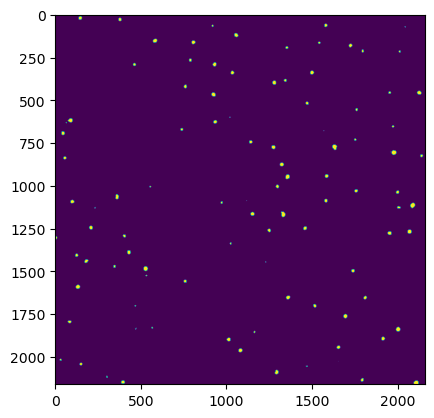

In [143]:
plt.imshow(pr_mask)

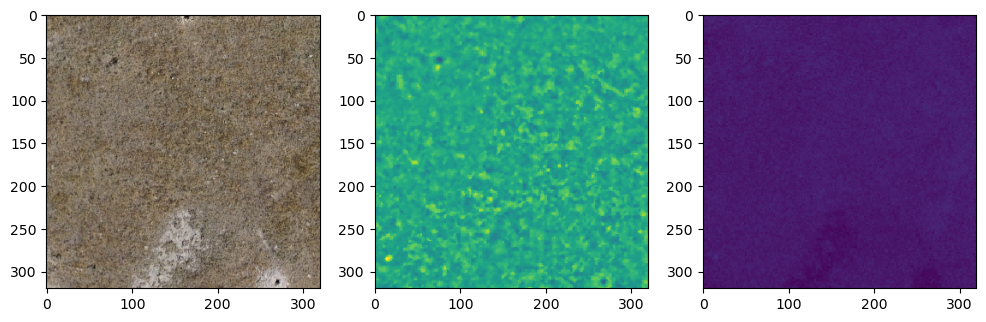

In [103]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 6))
axs[0].imshow(image_sub_dict['rgb'].transpose((1, 2, 0)))
#axs[1].imshow(dsm_xr.data)
axs[1].imshow(image_sub_dict['tpi'].squeeze(), clim=(-0.1, 0.4))
axs[2].imshow(image_sub_dict['ndvi'].squeeze(), clim=(0, 1))
#axs[2].imshow(ms_xr.sel(band=4).data)

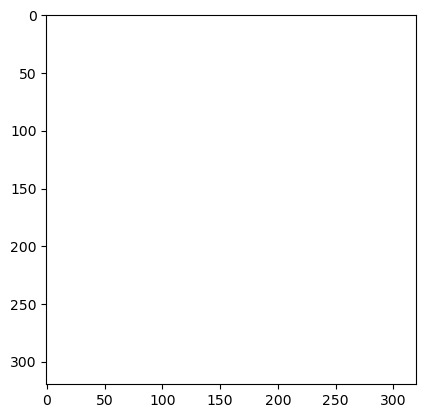

In [79]:
image_list = [image_sub_dict[i] for i in inputs_fnl]
image_out = np.concatenate(image_list, axis=0)
x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
test = best_model.predict(x_tensor).cpu().detach().numpy().squeeze()
plt.imshow(test)

In [83]:
for i in range(image_out.shape[0]):
    print(np.any(np.isnan(image_out[i, :, :])))
#(np.isnan(image_out))

False
False
False
True
False


In [140]:
np.sum(np.isnan(image_out[3, :, :]))

0

In [127]:
from scipy.interpolate import NearestNDInterpolator

In [133]:
mask = np.isnan(image_out[3, :, :])
idx = np.where(~mask,np.arange(mask.shape[1]),0)
np.maximum.accumulate(idx,axis=1, out=idx)
out = image_out[3, :, :][np.arange(idx.shape[0])[:,None], idx]

TypeError: Invalid shape (1, 320, 320, 320) for image data

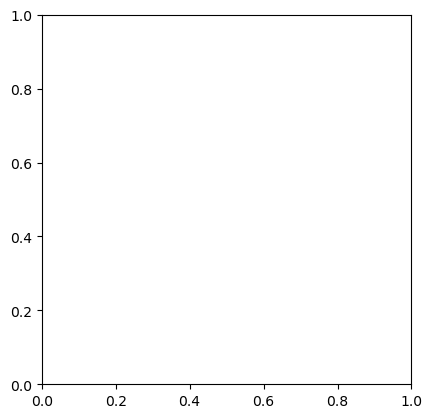

In [138]:
np.sum(np.isnan(out))
plt.imshow(out)

In [108]:
test = calc_tpi(dsm_xr.chunk({'x': chunk_size,
                                                       'y': chunk_size}), 
                                         inner_r=inner_radius, 
                                         outer_r=outer_radius, 
                                         interpolate=True,
                                         values=True)

In [125]:
dsm_xr.fillna(dsm_xr.attrs.get('_FillValue')).interpolate_na(dim='x')

<xarray.DataArray (y: 2160, x: 2160)>
array([[  1639.9738,   1640.0032,   1640.0032, ...,   1641.2946,
          1641.2933, -32767.    ],
       [  1639.9736,   1639.9816,   1639.9816, ...,   1641.2931,
          1641.2843, -32767.    ],
       [  1639.9736,   1639.9816,   1639.9816, ...,   1641.2931,
          1641.2843, -32767.    ],
       ...,
       [  1639.1031,   1639.1033,   1639.1033, ...,   1639.3579,
          1639.3572, -32767.    ],
       [  1639.1033,   1639.1033,   1639.1033, ...,   1639.357 ,
          1639.357 , -32767.    ],
       [  1639.095 ,   1639.093 ,   1639.093 , ...,   1639.357 ,
          1639.3555, -32767.    ]], dtype=float32)
Coordinates:
  * x            (x) float64 5.256e+05 5.256e+05 ... 5.257e+05 5.257e+05
  * y            (y) float64 4.523e+06 4.523e+06 ... 4.523e+06 4.523e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  15.12308179247889
    STATISTICS_MAXIMUM:      1717.7796630859
    STATISTICS_MEAN:         1646.2868596869
    STATISTICS_MINIMUM:      1619.9622802734
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       3.8888406746071
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -32767.0

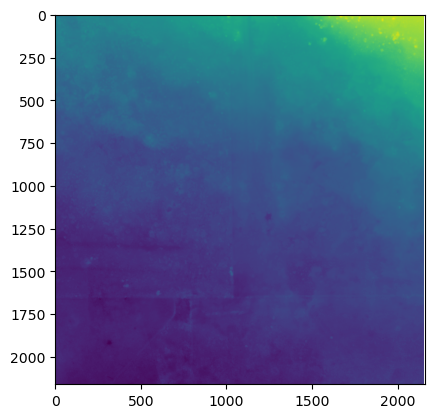

In [110]:
plt.imshow(dsm_xr.values)

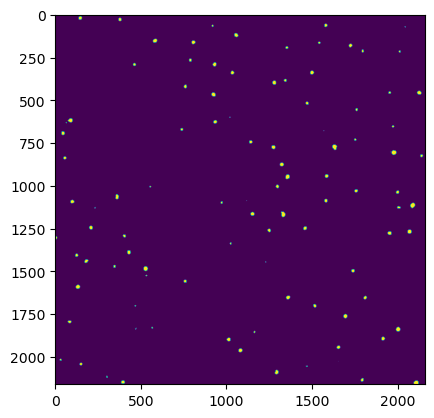

In [141]:
plt.imshow(pr_mask)

In [69]:
plt.imshow()